In [29]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from typing import Tuple

def are_duplicates(line_a, line_b, rho_threshold, theta_threshold):
    rho_a, theta_a = line_a[0]
    rho_b, theta_b = line_b[0]

    if rho_a < 0:
        rho_a = -rho_a
        theta_a += np.pi

    if rho_b < 0:
        rho_b = -rho_b
        theta_b += np.pi

    rho_diff = (theta_a - theta_b + np.pi) % (2 * np.pi) - np.pi

    if abs(rho_diff) < theta_threshold and abs(rho_a - rho_b) < rho_threshold:
        return True
    else:
        return False


def is_axis_aligned(line, threshold):
    rho, theta = line[0]

    if 0 <= theta <= threshold or np.pi - threshold <= theta <= np.pi or np.pi/2 - threshold <= theta <= np.pi/2 + threshold:
        return True
    else:
        return False


def auto_canny(image, sigma=0.33):
	# compute the median of the single channel pixel intensities
	v = np.median(image)
	# apply automatic Canny edge detection using the computed median
	lower = int(max(0, (1.0 - sigma) * v))
	upper = int(min(255, (1.0 + sigma) * v))
	edged = cv2.Canny(image, lower, upper)
	# return the edged image
	return edged


def apply_brightness_contrast(input_img, brightness = 0, contrast = 0):

    if brightness != 0:
        if brightness > 0:
            shadow = brightness
            highlight = 255
        else:
            shadow = 0
            highlight = 255 + brightness
        alpha_b = (highlight - shadow)/255
        gamma_b = shadow

        buf = cv2.addWeighted(input_img, alpha_b, input_img, 0, gamma_b)
    else:
        buf = input_img.copy()

    if contrast != 0:
        f = 131*(contrast + 127)/(127*(131-contrast))
        alpha_c = f
        gamma_c = 127*(1-f)

        buf = cv2.addWeighted(buf, alpha_c, buf, 0, gamma_c)

    return buf


def is_horizontal(line, threshold):
    rho, theta = line[0]

    if np.pi/2 - threshold <= theta <= np.pi/2 + threshold:
        return True
    else:
        return False


def is_vertical(line, threshold):
    rho, theta = line[0]

    if 0 <= theta <= threshold or np.pi - threshold <= theta <= np.pi:
        return True
    else:
        return False


def preprocess_image(img):
    img = cv2.resize(img, (512, 512))
    img = apply_brightness_contrast(img, 32, 32)

    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    blurred = cv2.GaussianBlur(gray, (7, 7), 0)

    edges = auto_canny(blurred)

    return edges

def find_lines(edges: np.ndarray) -> Tuple[np.ndarray, np.ndarray]:
    lines = cv2.HoughLines(edges, rho = 1,theta = 1*np.pi/180,threshold = 50)
    lines = lines[:50]
    lines = np.array([
        line for index, line in enumerate(lines) if
        all([not are_duplicates(x, line, 20, 10*np.pi/180) for x in lines[:index]])
    ])

    h_lines = np.array([line for line in lines if is_horizontal(line, 10*np.pi/180)])
    v_lines = np.array([line for line in lines if is_vertical(line, 10*np.pi/180)])

    return h_lines, v_lines


def overlay_lines(img, lines, color):
    img = img.copy()

    for line in lines:
        rho,theta = line[0]
        a = np.cos(theta)
        b = np.sin(theta)
        x0 = a*rho
        y0 = b*rho
        x1 = int(x0 + 1000*(-b))
        y1 = int(y0 + 1000*(a))
        x2 = int(x0 - 1000*(-b))
        y2 = int(y0 - 1000*(a))

        cv2.line(img, (x1,y1), (x2,y2), color, 1)

    return img

In [30]:
def intersection(line1, line2):
    rho1, theta1 = line1[0]
    rho2, theta2 = line2[0]
    A = np.array([
        [np.cos(theta1), np.sin(theta1)],
        [np.cos(theta2), np.sin(theta2)]
    ])
    b = np.array([[rho1], [rho2]])
    x0, y0 = np.linalg.solve(A, b)
    x0, y0 = int(np.round(x0)), int(np.round(y0))
    return [x0, y0]


def segmented_intersections(h_lines, v_lines):
    intersections = []
    for h_line in h_lines:
        for v_line in v_lines:
            intersections.append(intersection(h_line, v_line))

    return intersections

def overlay_markers(img, points):
    img = img.copy()
    for x, y in points:
        cv2.drawMarker(img, (x, y), 20, thickness = 5)
    return img

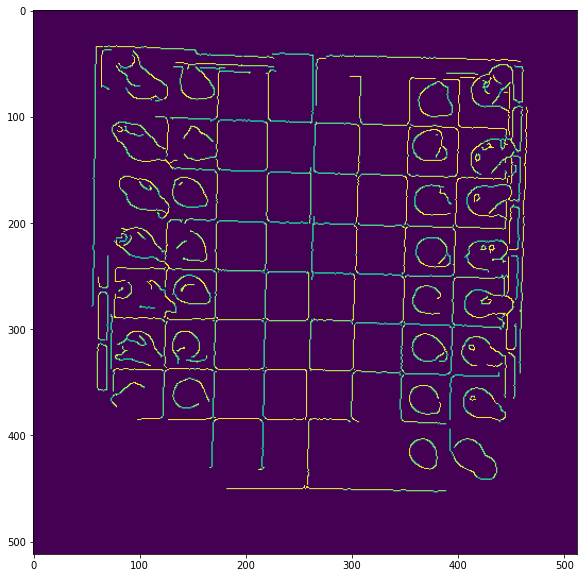

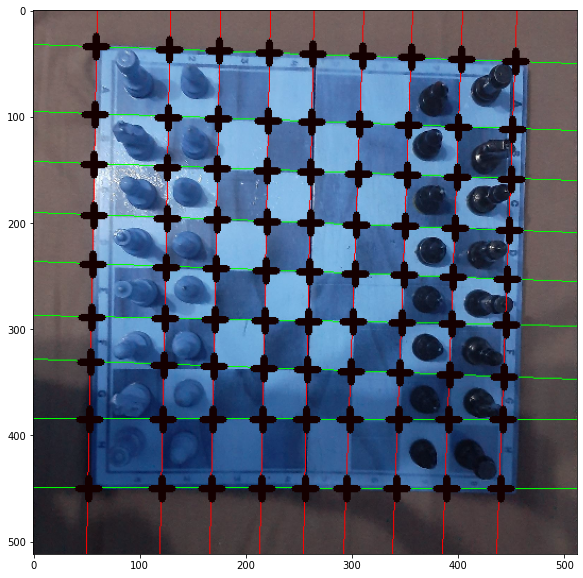

In [31]:
img = cv2.imread("test8.jpg", cv2.IMREAD_COLOR)
img = cv2.resize(img, (512, 512))

overlayed_frame = img.copy()

edges = preprocess_image(img)
h_lines, v_lines = find_lines(edges)

plt.figure(figsize = (10,10))
plt.imshow(edges)
plt.show()

overlayed_frame = overlay_lines(overlayed_frame, v_lines, (255, 0, 0))
overlayed_frame = overlay_lines(overlayed_frame, h_lines, (0, 255, 0))

intersections = np.array(segmented_intersections(h_lines, v_lines))

overlayed_frame = overlay_markers(overlayed_frame, intersections)

plt.figure(figsize = (10,10))
plt.imshow(overlayed_frame)
plt.show()

In [3]:
import cv2
import numpy as np

# Create a VideoCapture object
cap = cv2.VideoCapture(0)

# Check if camera opened successfully
if (cap.isOpened() == False):
  print("Unable to read camera feed")

# Default resolutions of the frame are obtained.The default resolutions are system dependent.
# We convert the resolutions from float to integer.
frame_width = int(cap.get(3))
frame_height = int(cap.get(4))
frame_size = min([frame_width, frame_height])

# Define the codec and create VideoWriter object.The output is stored in 'outpy.avi' file.
# out = cv2.VideoWriter('outpy.avi',cv2.VideoWriter_fourcc('M','J','P','G'), 10, (512, 512))

while True:
    ret, frame = cap.read()

    frame = frame[(frame_height - frame_size)//2 : frame_height - (frame_height - frame_size)//2, (frame_width - frame_size)//2 : frame_width - (frame_width - frame_size)//2]
    frame = cv2.resize(frame, (512, 512))
    overlayed_frame = frame.copy()

    h_lines, v_lines = find_lines(frame)

    overlayed_frame = overlay_lines(overlayed_frame, v_lines, (255, 0, 0))
    overlayed_frame = overlay_lines(overlayed_frame, h_lines, (0, 255, 0))

    intersections = np.array(segmented_intersections(h_lines, v_lines))

    overlayed_frame = overlay_markers(overlayed_frame, intersections)

    if ret == True:
        # out.write(frame)
        # print(overlayed_frame.shape)
        cv2.imshow('frame', overlayed_frame)
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break
    else:
        break

# When everything done, release the video capture and video write objects
cap.release()
# out.release()

# Closes all the frames
cv2.destroyAllWindows()

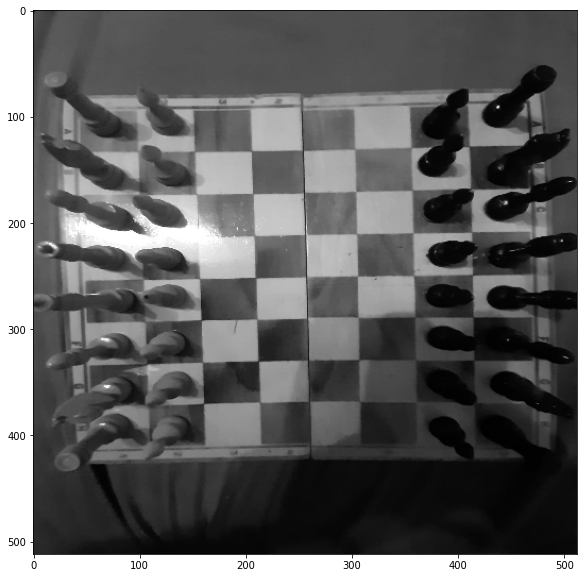

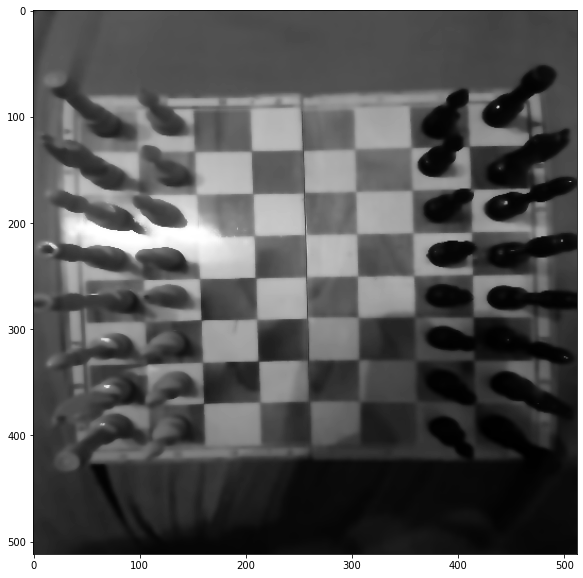

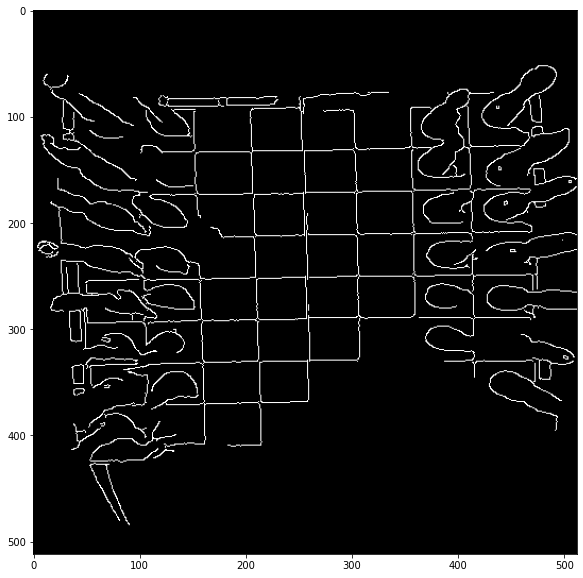

In [4]:
img = cv2.imread("test4.jpg", cv2.IMREAD_GRAYSCALE)
img = cv2.resize(img, (512, 512))

# img = ((img/255.0)**2 * 255).astype(np.uint8)

# edges = cv2.Canny(img, 50,200, apertureSize = 3)

# Smoothing without removing edges.
gray_filtered = cv2.bilateralFilter(img, 7, 50, 50)

# Applying the canny filter
# edges = cv2.Canny(gray, 60, 120)
edges = cv2.Canny(gray_filtered, 50, 200)

# kernel = np.ones((5,5), np.uint8) 
# edges = cv2.dilate(edges, kernel, iterations=1) 
# edges = cv2.erode(edges, kernel, iterations=1) 

plt.figure(figsize = (10,10))
plt.imshow(img, cmap='gray')
plt.show()

plt.figure(figsize = (10,10))
plt.imshow(gray_filtered, cmap='gray')
plt.show()

plt.figure(figsize = (10,10))
plt.imshow(edges, cmap='gray')
plt.show()

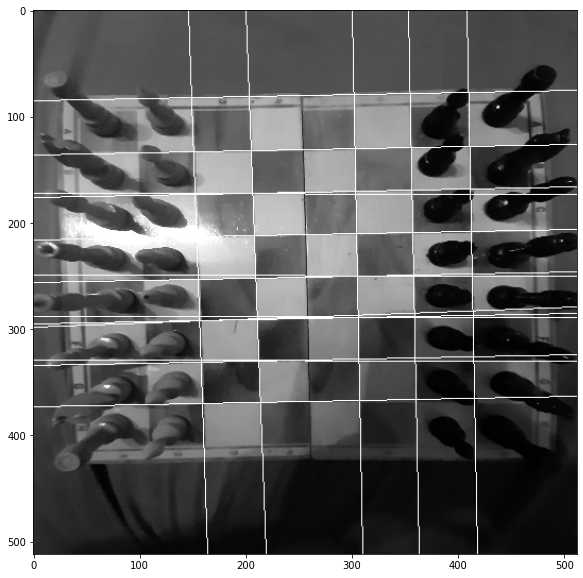

(18, 1, 2)

In [5]:
# bg = np.zeros_like(edges)

# _, thresh = cv2.threshold(edges,0,255,cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)

imgcopy = img.copy()

lines = cv2.HoughLines(edges, rho = 1,theta = 1*np.pi/180,threshold = 100)

lines = lines[:100]

for line in lines:
    for rho,theta in line:
            a = np.cos(theta)
            b = np.sin(theta)
            x0 = a*rho
            y0 = b*rho
            x1 = int(x0 + 1000*(-b))
            y1 = int(y0 + 1000*(a))
            x2 = int(x0 - 1000*(-b))
            y2 = int(y0 - 1000*(a))

            cv2.line(imgcopy,(x1,y1),(x2,y2),255,1)

plt.figure(figsize = (10,10))
plt.imshow(imgcopy, cmap='gray')
plt.show()

lines.shape

# Auto canny + Blur + HoughLines

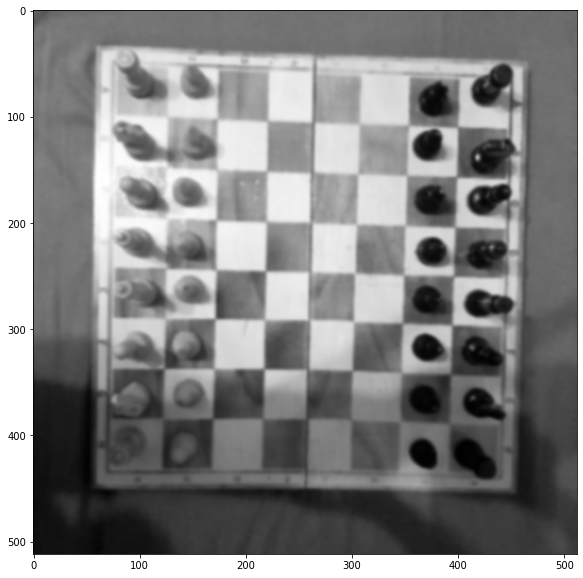

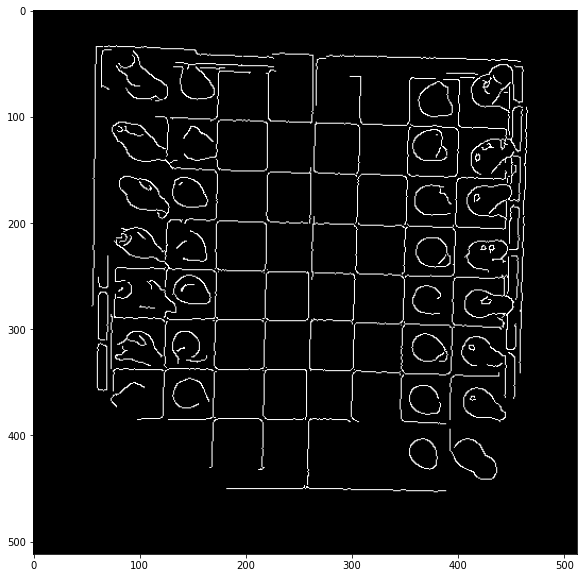

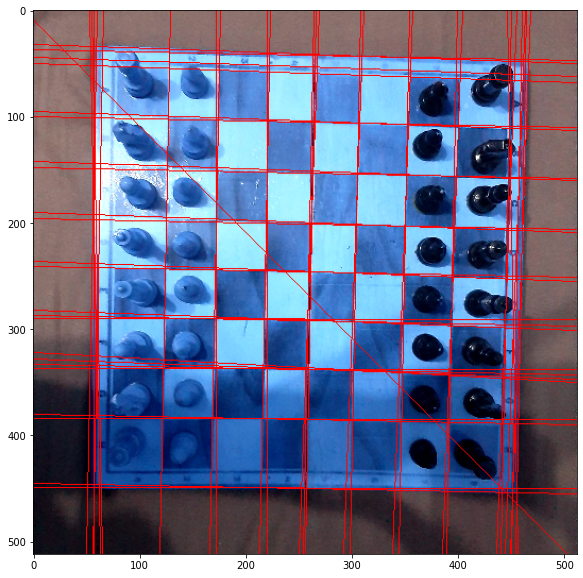

In [6]:
import cv2
import numpy as np


img = cv2.imread('test8.jpg', cv2.IMREAD_COLOR)

img = apply_brightness_contrast(img, 32, 32)

img = cv2.resize(img, (512, 512))
# Convert the image to gray-scale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

blurred = cv2.GaussianBlur(gray, (7, 7), 0)
edges = auto_canny(blurred)

# kernel = np.ones((5,5), np.uint8) 
# edges = cv2.dilate(edges, kernel, iterations=1)
# edges = cv2.erode(edges, kernel, iterations=2) 

lines = cv2.HoughLines(edges, rho = 1,theta = 1*np.pi/180,threshold = 50)

lines = lines[:50]

for line in lines:
    for rho,theta in line:
            a = np.cos(theta)
            b = np.sin(theta)
            x0 = a*rho
            y0 = b*rho
            x1 = int(x0 + 1000*(-b))
            y1 = int(y0 + 1000*(a))
            x2 = int(x0 - 1000*(-b))
            y2 = int(y0 - 1000*(a))

            cv2.line(img,(x1,y1),(x2,y2),255,1)


plt.figure(figsize = (10,10))
plt.imshow(blurred, cmap='gray')
plt.show()

plt.figure(figsize = (10,10))
plt.imshow(edges, cmap='gray')
plt.show()

plt.figure(figsize = (10,10))
plt.imshow(img)
plt.show()

(50, 1, 2)
(16, 1, 2)


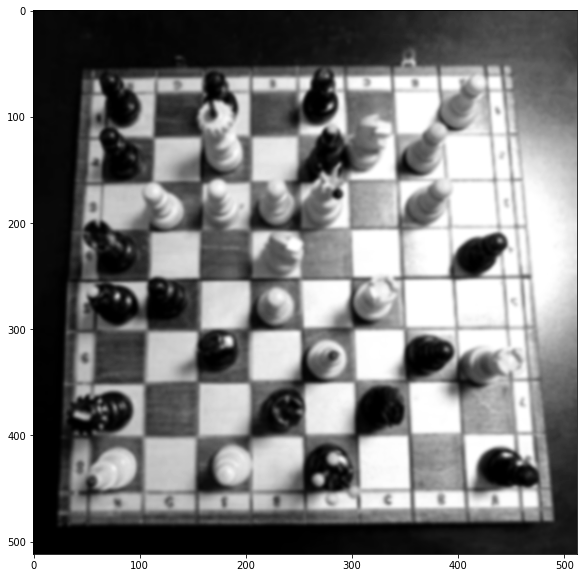

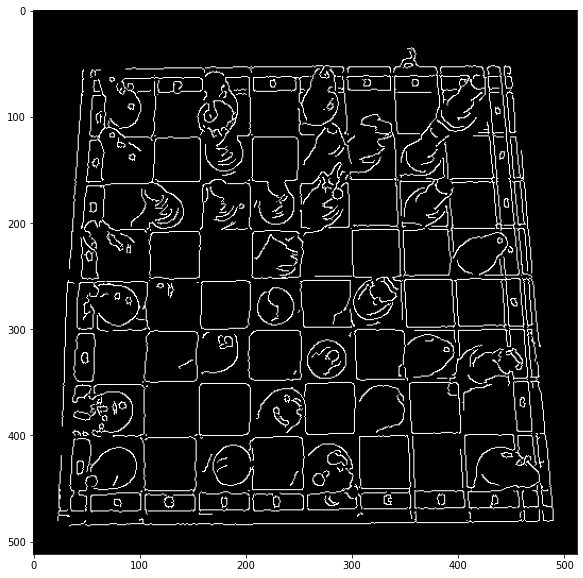

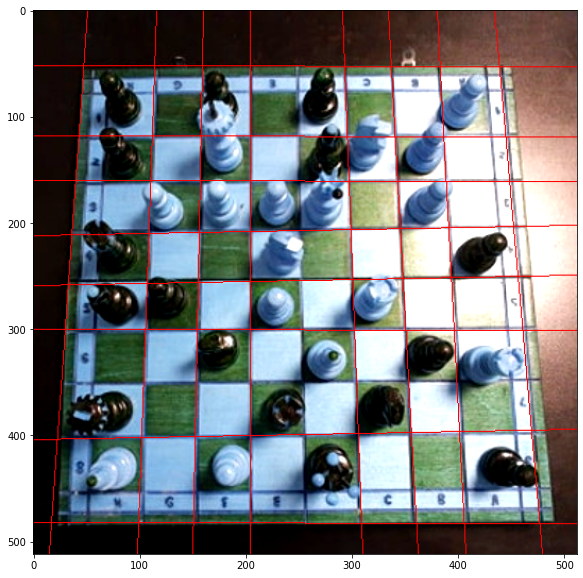

In [7]:
import cv2
import numpy as np

img = cv2.imread('test7.jpg', cv2.IMREAD_COLOR)
img = cv2.resize(img, (512, 512))
img = apply_brightness_contrast(img, 32, 32)
# Convert the image to gray-scale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

blurred = cv2.GaussianBlur(gray, (7, 7), 0)
edges = auto_canny(blurred)

# kernel = np.ones((3,3), np.uint8) 
# edges = cv2.dilate(edges, kernel, iterations=1)
# edges = cv2.erode(edges, kernel, iterations=2) 

lines = cv2.HoughLines(edges, rho = 1,theta = 1*np.pi/180,threshold = 50)

lines = lines[:50]

print(lines.shape)

lines = np.array([
    line for index, line in enumerate(lines) if 
    all([not are_duplicates(x, line, 20, 10*np.pi/180) for x in lines[:index]]) 
    and is_axis_aligned(line, 10*np.pi/180)
])

print(lines.shape)


for line in lines:
    for rho,theta in line:
            a = np.cos(theta)
            b = np.sin(theta)
            x0 = a*rho
            y0 = b*rho
            x1 = int(x0 + 1000*(-b))
            y1 = int(y0 + 1000*(a))
            x2 = int(x0 - 1000*(-b))
            y2 = int(y0 - 1000*(a))

            cv2.line(img,(x1,y1),(x2,y2),255,1)


plt.figure(figsize = (10,10))
plt.imshow(blurred, cmap='gray')
plt.show()

plt.figure(figsize = (10,10))
plt.imshow(edges, cmap='gray')
plt.show()

plt.figure(figsize = (10,10))
plt.imshow(img)
plt.show()


# Auto canny + Blur + HoughLinesP

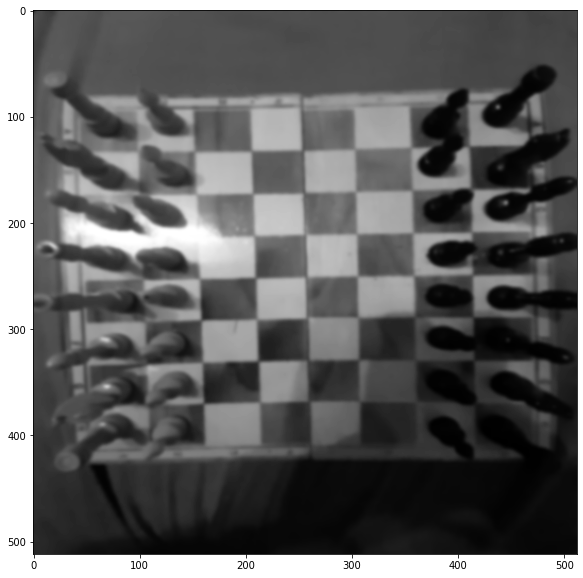

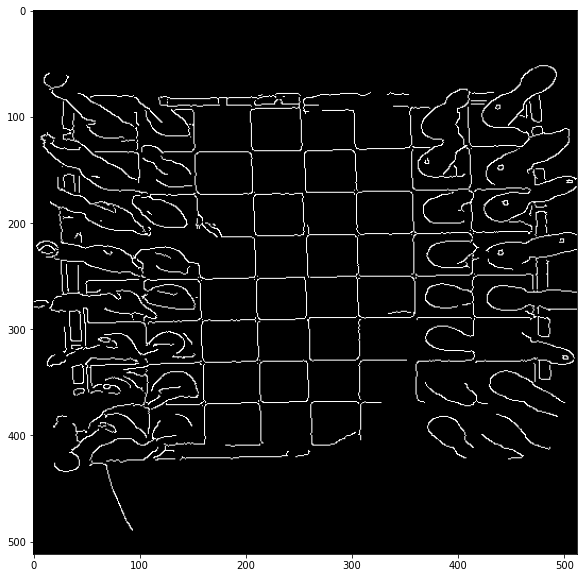

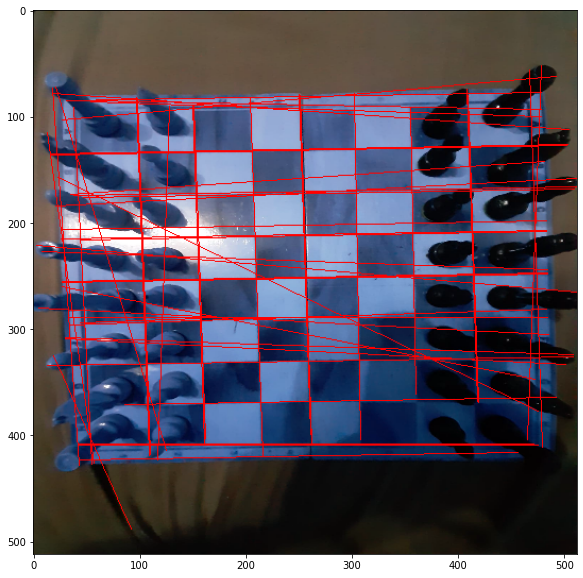

In [8]:
def auto_canny(image, sigma=0.33):
	# compute the median of the single channel pixel intensities
	v = np.median(image)
	# apply automatic Canny edge detection using the computed median
	lower = int(max(0, (1.0 - sigma) * v))
	upper = int(min(255, (1.0 + sigma) * v))
	edged = cv2.Canny(image, lower, upper)
	# return the edged image
	return edged


import cv2
import numpy as np

img = cv2.imread('test4.jpg', cv2.IMREAD_COLOR)
img = cv2.resize(img, (512, 512))
# Convert the image to gray-scale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

blurred = cv2.GaussianBlur(gray, (7, 7), 0)
edges = auto_canny(blurred)

kernel = np.ones((3,3), np.uint8) 
# edges = cv2.dilate(edges, kernel, iterations=1)
# edges = cv2.erode(edges, kernel, iterations=1) 

lines = cv2.HoughLinesP(edges, rho = 1,theta = 1*np.pi/180,threshold = 20, minLineLength=20, maxLineGap=150)
for line in lines[:50]:
    x1, y1, x2, y2 = line[0]
    cv2.line(img, (x1, y1), (x2, y2), (255, 0, 0), 1)


plt.figure(figsize = (10,10))
plt.imshow(blurred, cmap='gray')
plt.show()

plt.figure(figsize = (10,10))
plt.imshow(edges, cmap='gray')
plt.show()

plt.figure(figsize = (10,10))
plt.imshow(img)
plt.show()

# Manual canny + Blur + HoughLines

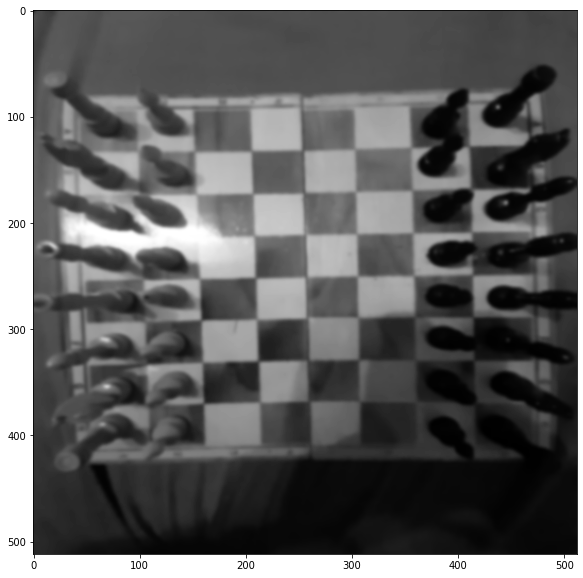

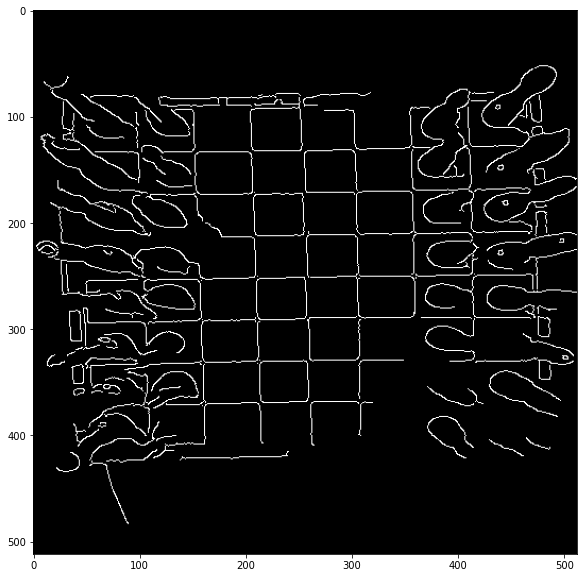

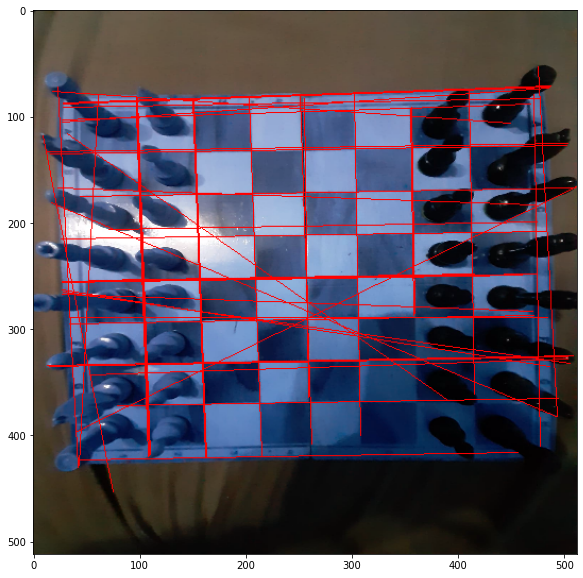

In [9]:
import cv2
import numpy as np

img = cv2.imread('test4.jpg', cv2.IMREAD_COLOR)
img = cv2.resize(img, (512, 512))
# Convert the image to gray-scale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

blurred = cv2.GaussianBlur(gray, (7, 7), 0)

# Applying the canny filter
edges = cv2.Canny(blurred, 60, 120)

# Detect points that form a line
lines = cv2.HoughLinesP(edges, rho = 1,theta = 1*np.pi/180,threshold = 50, minLineLength=10, maxLineGap=500)
# Draw lines on the image
for line in lines[:50]:
    x1, y1, x2, y2 = line[0]
    cv2.line(img, (x1, y1), (x2, y2), (255, 0, 0), 1)


plt.figure(figsize = (10,10))
plt.imshow(blurred, cmap='gray')
plt.show()

plt.figure(figsize = (10,10))
plt.imshow(edges, cmap='gray')
plt.show()

plt.figure(figsize = (10,10))
plt.imshow(img)
plt.show()